# LLM Explainability for Financial Sentiment Analysis
### Comparing SHAP and LIME on FinBERT

In this project, we load a real-world financial tweet dataset, run sentiment predictions using FinBERT, and apply two explainability techniques — SHAP and LIME — to understand why the model makes certain predictions. We then compare both methods to identify where they agree and where they differ.


## Step 1: Load the Dataset

We use the Twitter Financial News Sentiment dataset from HuggingFace. It contains financial tweets labeled as bullish, bearish, or neutral by human analysts.

In [3]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
df = pd.DataFrame(dataset['train'])
df.columns = ['text', 'label']

label_map = {0: 'bearish', 1: 'bullish', 2: 'neutral'}
df['true_label'] = df['label'].map(label_map)

label_remap = {'bullish': 'positive', 'bearish': 'negative', 'neutral': 'neutral'}
df['true_label_mapped'] = df['true_label'].map(label_remap)

print(df.shape)
print(df['true_label_mapped'].value_counts())
df[['text', 'true_label_mapped']].head()

(9543, 4)
true_label_mapped
neutral     6178
positive    1923
negative    1442
Name: count, dtype: int64


,text,true_label_mapped
0,$BYND - JPMorgan reels in expectations on Beyo...,negative
1,$CCL $RCL - Nomura points to bookings weakness...,negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",negative
3,$ESS: BTIG Research cuts to Neutral https://t....,negative
4,$FNKO - Funko slides after Piper Jaffray PT cu...,negative


### Step 1 Result

The dataset contains 9,543 financial tweets across three sentiment classes:
- Neutral: 6,178 (65%)
- Positive: 1,923 (20%)
- Negative: 1,442 (15%)

The dataset is imbalanced, with neutral tweets dominating. This is expected in financial news since most market updates are factual rather than directionally positive or negative. This imbalance will likely influence FinBERT's performance, particularly on the minority classes.

## Step 2: Run FinBERT on the Full Dataset

FinBERT is a BERT model fine-tuned on financial text. We run it across all 9,543 tweets and save predictions to a CSV to avoid recomputation.

In [4]:
from transformers import pipeline

finbert = pipeline("text-classification", model="ProsusAI/finbert", top_k=None)

def get_top_label(text):
    try:
        scores = finbert(str(text)[:512])[0]
        return max(scores, key=lambda x: x['score'])['label']
    except:
        return 'neutral'

df['predicted_label'] = df['text'].apply(get_top_label)
df.to_csv('finbert_predictions.csv', index=False)
df[['text', 'true_label_mapped', 'predicted_label']].head()

C:\Users\PRASAD\anaconda3\envs\llm_explain\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,text,true_label_mapped,predicted_label
0,$BYND - JPMorgan reels in expectations on Beyo...,negative,negative
1,$CCL $RCL - Nomura points to bookings weakness...,negative,negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",negative,negative
3,$ESS: BTIG Research cuts to Neutral https://t....,negative,neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,negative,negative


### Step 2 Result

FinBERT successfully ran on all 9,543 tweets. From the first 5 rows we can 
already see one misclassification — "$ESS: BTIG Research cuts to Neutral" 
was predicted as neutral when the true label is negative. This is an 
interesting case where the word "Neutral" in the tweet itself likely 
confused the model.

Predictions saved to finbert_predictions.csv.

## Step 3: Evaluate FinBERT Performance

We evaluate predictions using a classification report and confusion matrix 
to understand where the model performs well and where it struggles.

              precision    recall  f1-score   support

    negative       0.50      0.78      0.61      1442
     neutral       0.85      0.73      0.79      6178
    positive       0.58      0.60      0.59      1923

    accuracy                           0.71      9543
   macro avg       0.64      0.70      0.66      9543
weighted avg       0.74      0.71      0.72      9543



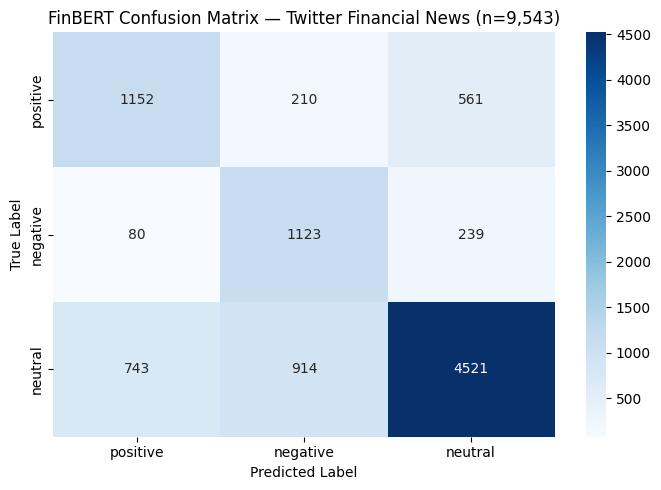

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(df['true_label_mapped'], df['predicted_label']))

cm = confusion_matrix(df['true_label_mapped'], df['predicted_label'],
                      labels=['positive', 'negative', 'neutral'])

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.title('FinBERT Confusion Matrix — Twitter Financial News (n=9,543)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 3 Result

FinBERT achieved 71% overall accuracy on 9,543 financial tweets.

Key observations:
- Neutral class performs best (F1: 0.79) which is expected given it 
  dominates the dataset with 6,178 examples
- Negative class has the lowest precision (0.50), meaning the model 
  incorrectly flags neutral tweets as negative roughly half the time
- Positive class has the lowest recall (0.60), meaning the model misses 
  40% of actually positive tweets

From the confusion matrix the most critical finding is that 914 neutral 
tweets were predicted as negative. In a real finance context this is 
costly — a risk system flagging neutral news as bearish could trigger 
unnecessary trading decisions.

This is exactly why explainability matters. 71% accuracy is not enough 
on its own. We need to understand which words are causing these errors.

## Step 4: Select Examples for Explainability

We select 50 examples for SHAP and LIME analysis — 25 correctly classified 
and 25 misclassified — balanced across sentiment classes. This gives us a 
representative view of both model strengths and failure modes.

In [7]:
correct = df[df['true_label_mapped'] == df['predicted_label']].groupby('true_label_mapped').head(9).head(25)
wrong = df[df['true_label_mapped'] != df['predicted_label']].groupby('true_label_mapped').head(9).head(25)
explain_df = pd.concat([correct, wrong]).reset_index(drop=True)
explain_df['is_correct'] = explain_df['true_label_mapped'] == explain_df['predicted_label']

print(explain_df['is_correct'].value_counts())
print(explain_df['true_label_mapped'].value_counts())
explain_df[['text', 'true_label_mapped', 'predicted_label', 'is_correct']].head(10)

is_correct
True     25
False    25
Name: count, dtype: int64
true_label_mapped
negative    18
positive    18
neutral     14
Name: count, dtype: int64


,text,true_label_mapped,predicted_label,is_correct
0,$BYND - JPMorgan reels in expectations on Beyo...,negative,negative,True
1,$CCL $RCL - Nomura points to bookings weakness...,negative,negative,True
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",negative,negative,True
3,$FNKO - Funko slides after Piper Jaffray PT cu...,negative,negative,True
4,$GM - GM loses a bull https://t.co/tdUfG5HbXy,negative,negative,True
5,$GTT: Cowen cuts to Market Perform,negative,negative,True
6,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,negative,negative,True
7,"$HXL - Citing aero ties, Wells slashes PT on H...",negative,negative,True
8,$I - Intelsat cut to Market Perform at Raymond...,negative,negative,True
9,$AMD - AMD's Navi shows strong adoption - BofA...,positive,positive,True


### Step 4 Result

We have 50 examples selected — 25 correctly classified and 25 misclassified, 
spread across negative (18), positive (18), and neutral (14) classes.

This balanced selection ensures our explainability analysis covers both 
cases where FinBERT succeeds and where it fails, giving us a complete 
picture of model behavior.

## Step 5: SHAP Analysis

SHAP assigns each word a value representing how much it contributed to 
the model's prediction. Positive values push toward the predicted class, 
negative values push away. We store all results to a CSV for later analysis.

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import shap

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()

def predict(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    texts = [str(t) for t in texts]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=1).detach().numpy()

label_to_idx = {'positive': 0, 'negative': 1, 'neutral': 2}
masker = shap.maskers.Text(r"\W+")
explainer = shap.Explainer(predict, masker)

shap_records = []
for _, row in explain_df.iterrows():
    text = str(row['text'])[:200]
    pred_idx = label_to_idx[row['predicted_label']]
    sv = explainer([text])
    for word, value in zip(sv[0].data, sv[0].values[:, pred_idx]):
        shap_records.append({
            'text': text,
            'word': word,
            'shap_value': value,
            'predicted_label': row['predicted_label'],
            'true_label': row['true_label_mapped'],
            'is_correct': row['is_correct']
        })

shap_df = pd.DataFrame(shap_records)
shap_df.to_csv('shap_values.csv', index=False)
shap_df.head(10)

C:\Users\PRASAD\anaconda3\envs\llm_explain\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
PartitionExplainer explainer: 2it [00:14, 14.19s/it]                                                                   


  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.71s/it]                                                                   


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.96s/it]                                                                   


,text,word,shap_value,predicted_label,true_label,is_correct
0,$BYND - JPMorgan reels in expectations on Beyo...,$,0.039418,negative,negative,True
1,$BYND - JPMorgan reels in expectations on Beyo...,BYND -,0.085486,negative,negative,True
2,$BYND - JPMorgan reels in expectations on Beyo...,JPMorgan,0.087252,negative,negative,True
3,$BYND - JPMorgan reels in expectations on Beyo...,reels,0.611310,negative,negative,True
4,$BYND - JPMorgan reels in expectations on Beyo...,in,-0.142845,negative,negative,True
5,$BYND - JPMorgan reels in expectations on Beyo...,expectations,0.105607,negative,negative,True
6,$BYND - JPMorgan reels in expectations on Beyo...,on,0.034113,negative,negative,True
7,$BYND - JPMorgan reels in expectations on Beyo...,Beyond,-0.045701,negative,negative,True
8,$BYND - JPMorgan reels in expectations on Beyo...,Meat,-0.051605,negative,negative,True
9,$BYND - JPMorgan reels in expectations on Beyo...,https://,-0.076554,negative,negative,True


### Step 5 Result

SHAP successfully computed word-level contributions for all 50 examples, 
stored as individual rows in shap_values.csv.

From the first example "$BYND - JPMorgan reels in expectations on Beyond Meat", 
the word "reels" (+0.61) is the dominant driver of the negative prediction, 
which aligns with financial intuition — "reels" implies a company struggling 
to meet expectations. Interestingly, "Beyond Meat" itself pushed slightly 
away from negative, suggesting the model responds more to action words 
than company names.

## Step 6: LIME Analysis

LIME perturbs the input by randomly removing words and observing prediction 
changes. We apply it to the same 50 examples for direct comparison with SHAP.

In [9]:
from lime.lime_text import LimeTextExplainer

lime_explainer = LimeTextExplainer(class_names=['positive', 'negative', 'neutral'])

def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=1).detach().numpy()

lime_records = []
for _, row in explain_df.iterrows():
    text = str(row['text'])[:200]
    pred_idx = label_to_idx[row['predicted_label']]
    exp = lime_explainer.explain_instance(text, predict_proba, num_features=10,
                                          num_samples=300, labels=[0, 1, 2])
    for word, score in exp.as_list(label=pred_idx):
        lime_records.append({
            'text': text,
            'word': word,
            'lime_score': score,
            'predicted_label': row['predicted_label'],
            'true_label': row['true_label_mapped'],
            'is_correct': row['is_correct']
        })

lime_df = pd.DataFrame(lime_records)
lime_df.to_csv('lime_values.csv', index=False)
lime_df.head(10)

,text,word,lime_score,predicted_label,true_label,is_correct
0,$BYND - JPMorgan reels in expectations on Beyo...,reels,0.346918,negative,negative,True
1,$BYND - JPMorgan reels in expectations on Beyo...,expectations,0.202909,negative,negative,True
2,$BYND - JPMorgan reels in expectations on Beyo...,JPMorgan,0.167180,negative,negative,True
3,$BYND - JPMorgan reels in expectations on Beyo...,bd0xbFGjkT,0.155002,negative,negative,True
4,$BYND - JPMorgan reels in expectations on Beyo...,Meat,-0.080097,negative,negative,True
5,$BYND - JPMorgan reels in expectations on Beyo...,Beyond,-0.068573,negative,negative,True
6,$BYND - JPMorgan reels in expectations on Beyo...,https,-0.053251,negative,negative,True
7,$BYND - JPMorgan reels in expectations on Beyo...,t,-0.050335,negative,negative,True
8,$BYND - JPMorgan reels in expectations on Beyo...,co,0.032666,negative,negative,True
9,$BYND - JPMorgan reels in expectations on Beyo...,BYND,0.029605,negative,negative,True


### Step 6 Result

LIME successfully computed word-level scores for all 50 examples, 
stored in lime_values.csv.

For the first tweet "$BYND - JPMorgan reels in expectations on Beyond Meat", 
LIME agrees with SHAP that "reels" is the strongest driver of negative 
sentiment. Both methods also agree that "Beyond Meat" slightly reduces 
the negative signal, suggesting the model associates the company name 
with neutral rather than negative context.

## Step 7: SHAP vs LIME - Aggregate Visualization

We compare the top words driving misclassifications across both methods 
to identify where they agree and where they diverge. This is the core 
finding of the project.

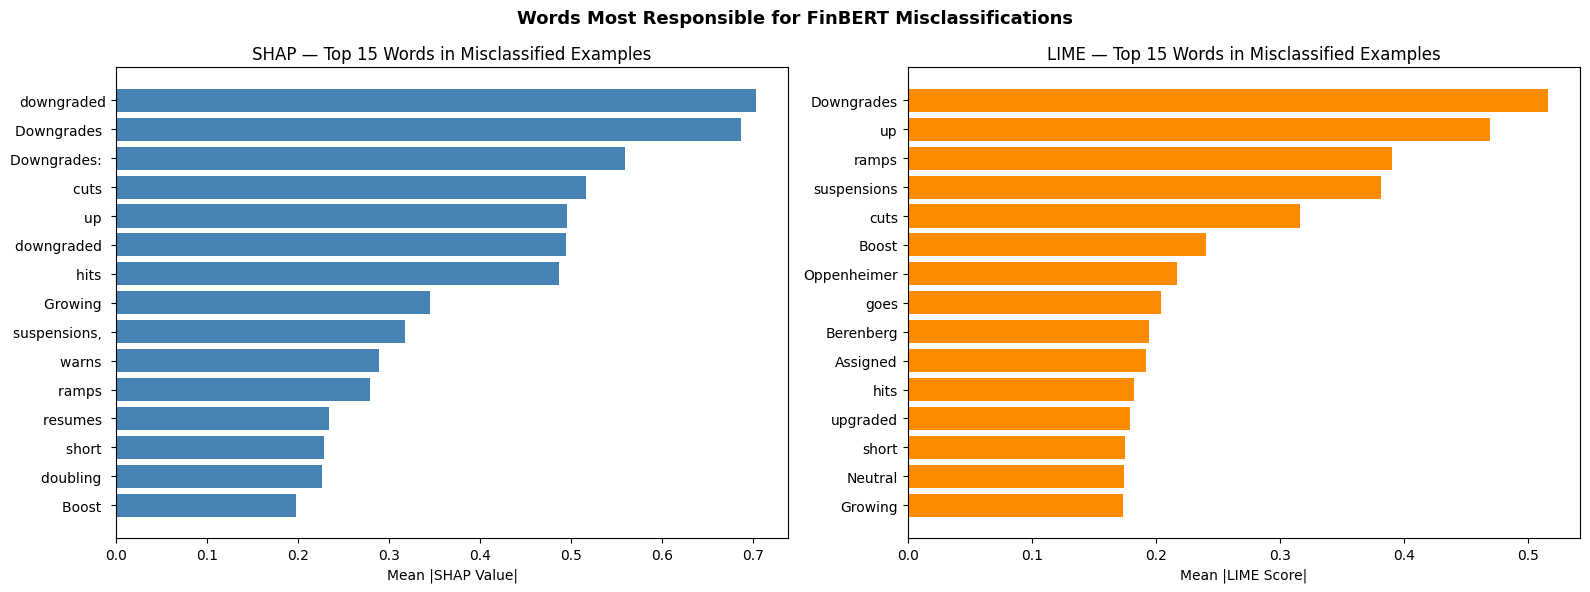

In [12]:
import matplotlib.pyplot as plt

shap_df = pd.read_csv('shap_values.csv')
lime_df = pd.read_csv('lime_values.csv')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

shap_wrong = shap_df[~shap_df['is_correct']]
top_shap = (shap_wrong.groupby('word')['shap_value']
            .mean().abs().sort_values(ascending=False).head(15))

axes[0].barh(top_shap.index[::-1], top_shap.values[::-1], color='steelblue')
axes[0].set_title('SHAP — Top 15 Words in Misclassified Examples')
axes[0].set_xlabel('Mean |SHAP Value|')

lime_wrong = lime_df[~lime_df['is_correct']]
top_lime = (lime_wrong.groupby('word')['lime_score']
            .mean().abs().sort_values(ascending=False).head(15))

axes[1].barh(top_lime.index[::-1], top_lime.values[::-1], color='darkorange')
axes[1].set_title('LIME — Top 15 Words in Misclassified Examples')
axes[1].set_xlabel('Mean |LIME Score|')

plt.suptitle('Words Most Responsible for FinBERT Misclassifications', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('aggregate_word_importance.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 7 Result

Both SHAP and LIME agree that "downgraded", "cuts", "up", and "hits" 
are the primary drivers of misclassification. These are contextually 
ambiguous words in finance — "up" and "hits" can signal both positive 
and negative sentiment depending on context.

LIME additionally surfaces analyst firm names like "Oppenheimer" and 
"Berenberg" as confusion sources, while SHAP focuses more on action 
verbs. This suggests SHAP captures linguistic patterns while LIME is 
more sensitive to named entities.

This finding has direct implications for model improvement — either 
fine-tuning FinBERT on tweet-style financial text or adding 
context-aware preprocessing for ambiguous terms.